In [1]:
import numpy as np
import os
import configparser

from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras import models

import sys
sys.path.insert(0, './lib/')
from help_functions import *

#function to obtain data for training/testing (validation)
from extract_patches import get_data_training

Using TensorFlow backend.


## custom U-net Model

In [2]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


In [3]:
def unet(n_ch,patch_height,patch_width):
    K.set_image_data_format('channels_first')
    inputs = layers.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Dropout(0.2)(conv1)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    #
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Dropout(0.2)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    #
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Dropout(0.2)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([conv2,up1],axis=1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv4 = layers.Dropout(0.2)(conv4)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    #
    up2 = layers.UpSampling2D(size=(2, 2),data_format='channels_first')(conv4)
    up2 = layers.concatenate([conv1,up2], axis=1)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv5 = layers.Dropout(0.2)(conv5)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    #
    conv6 = layers.Conv2D(2, (1, 1), activation='relu',padding='same')(conv5)
    conv6 = layers.core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = layers.core.Permute((2,1))(conv6)
    ############
    conv7 = layers.core.Activation('softmax')(conv6)

    model = models.Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [4]:
#for batch normalization
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = layers.Conv2D(filters=n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer= 'he_normal',
                     padding = 'same')(input_tensor)
    
    if batchnorm ==True:
        x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters=n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer= 'he_normal',
                     padding = 'same')(x)
    if batchnorm ==True:
        x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    return x




In [5]:
'''
For Attention block

[To Do]
    - Explain 'Function what to do'
    - Explain 'What is the self-attention in cnn?'
    - Explain 'Novelty of this system'

'''

def expend_as(tensor, rep, name):
    my_repeat = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis = 3), arguments={'repnum' : rep}, name = 'psi_up'+name)(tensor)
    return my_repeat

def AttnGatingBlock(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)
    
    print('shape x,g ', shape_x,shape_g)
    
    theta_x = layers.Conv2D(inter_shape, (2,2), strides=(2,2), padding='same', name = 'xl'+name)(x)
    shape_theta_x  = K.int_shape(theta_x)
    print('theha x,shape theta_x ', np.shape(theta_x), shape_theta_x)

    
    phi_g = layers.Conv2D(inter_shape, (1,1), padding='same')(g)
    
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    print('upsample_g ', np.shape(upsample_g))
    
    concat_xg = layers.merge.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    
    psi = layers.Conv2D(1, (1,1), padding= 'same', name = 'psi'+name)(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    
    upsample_psi = expend_as(upsample_psi, shape_x[3], name)
    
    y = layers.merge.multiply([upsample_psi, x], name = 'q_attn'+name)
    
    result = layers.Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    result_bn = layers.BatchNormalization(name='q_attn_bn'+name)(result)
    
    return result_bn

def UnetGatingSignal(input, is_batchnorm, name):
    '''
    this is simply 1x1 convolution, bn, activation
    '''
    
    shape = K.int_shape(input)
    x = layers.Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same", name=name + '_conv')(input)
    if is_batchnorm:
        x = layers.BatchNormalization(name=name + '_bn')(x)
    x = layers.Activation('relu', name = name+ '_act')(x)
    return x

In [6]:
def channel_attention(input_feature, ratio=8):
    print('input feature shape', input_feature._keras_shape)
    channel = input_feature._keras_shape[1]

    shared_layer_one = layers.Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    shared_layer_two = layers.Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    print('before reshpae avg pool', avg_pool._keras_shape)
    avg_pool = layers.Reshape((channel,1, 1))(avg_pool)
    print('after reshpae avg pool', avg_pool._keras_shape)

    avg_pool = shared_layer_one(avg_pool)
    print('after shared layer 01 avg pool', avg_pool._keras_shape)

    avg_pool = shared_layer_two(avg_pool)
    print('after shared layer 02 avg pool', avg_pool._keras_shape)


    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    print('before reshpae max pool', max_pool._keras_shape)

    max_pool = layers.Reshape((channel,1, 1))(max_pool)
    print('after reshpae max pool', max_pool._keras_shape)

    max_pool = shared_layer_one(max_pool)
    print('after shared layer 01 max pool', max_pool._keras_shape)

    max_pool = shared_layer_two(max_pool)
    print('before shared layer 02 max pool', max_pool._keras_shape)


    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)
    
    return layers.multiply([input_feature, cbam_feature])

def spatial_attention(input_feature, kernel_size=7):
        avg_pool = layers.Lambda(lambda x: K.mean(x, axis=1, keepdims=True))(input_feature)
        #print('shape of avg pool and input feature : ', np.shape(input_feature), np.shape(avg_pool))
        max_pool = layers.Lambda(lambda x: K.max(x, axis=1, keepdims=True))(input_feature)
        #print('shape of max pool and input feature : ', np.shape(input_feature), np.shape(max_pool))

        concat = layers.Concatenate(axis=1)([avg_pool, max_pool])
        
        cbam_feature = layers.Conv2D(filters=1,
                      kernel_size=kernel_size,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_initializer='he_normal',
                      use_bias=False)(concat)
        return layers.multiply([input_feature, cbam_feature])
    
def cbam_block(cbam_feature, ratio=2):
        # https://github.com/kobiso/CBAM-keras/blob/master/models/attention_module.py
        cbam_feature = channel_attention(cbam_feature, ratio)
        cbam_feature = spatial_attention(cbam_feature)
        return cbam_feature

In [7]:
def unet_norm(n_ch,patch_height,patch_width):
    K.set_image_data_format('channels_first')
    inputs = layers.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = conv2d_block(inputs, n_filters= 32, kernel_size=3, batchnorm=True)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    #
    conv2 = conv2d_block(pool1, n_filters= 64, kernel_size=3, batchnorm=True)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    #
    conv3 = conv2d_block(pool2, n_filters= 128, kernel_size=3, batchnorm=True)
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([conv2,up1],axis=1)
    
    
    conv4 = conv2d_block(up1, n_filters= 64, kernel_size=3, batchnorm=True)
    
    
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.concatenate([conv1,up2], axis=1)
    conv5 = conv2d_block(up2, n_filters= 32, kernel_size=3, batchnorm=True)
    
    conv6 = layers.Conv2D(2, (1, 1), activation='relu',padding='same')(conv5)
    
    conv6 = layers.core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = layers.core.Permute((2,1))(conv6)
    ############
    conv7 = layers.core.Activation('softmax')(conv6)

    model = models.Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [8]:
def naive_attn_unet(n_ch,patch_height,patch_width):
    K.set_image_data_format('channels_first')
    inputs = layers.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = conv2d_block(inputs, n_filters= 32, kernel_size=3, batchnorm=True)
    conv1 = layers.SpatialDropout2D(0.1)(conv1)
    conv1 = spatial_attention(conv1)
    
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    #
    conv2 = conv2d_block(pool1, n_filters= 64, kernel_size=3, batchnorm=True)
    conv2 = layers.SpatialDropout2D(0.1)(conv2)
    conv2 = spatial_attention(conv2)
    
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    #center
    conv3 = conv2d_block(pool2, n_filters= 128, kernel_size=3, batchnorm=True)
    conv3 = layers.SpatialDropout2D(0.4)(conv3)
    conv3 = spatial_attention(conv3)
    
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([conv2,up1],axis=1)
    conv4 = conv2d_block(up1, n_filters= 64, kernel_size=3, batchnorm=True)
    conv4 = spatial_attention(conv4)
    
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.concatenate([conv1,up2], axis=1)
    conv5 = conv2d_block(up2, n_filters= 32, kernel_size=3, batchnorm=True)
    conv5 = spatial_attention(conv5)
    
    conv6 = layers.Conv2D(2, (1, 1), activation='relu',padding='same')(conv5)
    
    conv6 = layers.core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = layers.core.Permute((2,1))(conv6)
    ############
    conv7 = layers.core.Activation('softmax')(conv6)

    model = models.Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=[dice_coef])
    model.summary()
    return model

In [9]:
def cbam_attn_unet(n_ch,patch_height,patch_width):
    K.set_image_data_format('channels_first')
    inputs = layers.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = conv2d_block(inputs, n_filters= 32, kernel_size=3, batchnorm=True)
    conv1 = layers.SpatialDropout2D(0.1)(conv1)
    conv1 = cbam_block(conv1)
    
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    #
    conv2 = conv2d_block(pool1, n_filters= 64, kernel_size=3, batchnorm=True)
    conv2 = layers.SpatialDropout2D(0.1)(conv2)
    conv2 = cbam_block(conv2)
    
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    #center
    conv3 = conv2d_block(pool2, n_filters= 128, kernel_size=3, batchnorm=True)
    conv3 = layers.SpatialDropout2D(0.4)(conv3)
    conv3 = cbam_block(conv3)
    
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([conv2,up1],axis=1)
    conv4 = conv2d_block(up1, n_filters= 64, kernel_size=3, batchnorm=True)
    conv4 = cbam_block(conv4)
    
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.concatenate([conv1,up2], axis=1)
    conv5 = conv2d_block(up2, n_filters= 32, kernel_size=3, batchnorm=True)
    conv5 = cbam_block(conv5)
    
    conv6 = layers.Conv2D(2, (1, 1), activation='relu',padding='same')(conv5)
    
    conv6 = layers.core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = layers.core.Permute((2,1))(conv6)
    ############
    conv7 = layers.core.Activation('softmax')(conv6)

    model = models.Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [10]:
def attn_unet(n_ch,patch_height,patch_width):
    K.set_image_data_format('channels_first')
    inputs = layers.Input(shape=(n_ch,patch_height,patch_width))
    conv1 = conv2d_block(inputs, n_filters= 32, kernel_size=3, batchnorm=True)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = conv2d_block(pool1, n_filters= 64, kernel_size=3, batchnorm=True)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    #center
    
    conv3 = conv2d_block(pool2, n_filters= 128, kernel_size=3, batchnorm=True)

    
    gating1 = UnetGatingSignal(conv3,True, 'gating01')
    
    attn1 = AttnGatingBlock(conv2, gating1, 128 ,'attn01')
    up1 = concatenate([Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same',activation="relu")(conv3), attn1], axis=3)
    
    gating2 = UnetGatingSignal(up1, True, 'gating02')
    attn2 = AttnGatingBlock(conv1, gating2, 64,'attn02' )
    up2 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same',activation="relu")(up1), attn2], axis=3)
    
    
    conv6 = layers.Conv2D(2, (1, 1), activation='relu',padding='same')(up2)
    
    conv6 = layers.core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = layers.core.Permute((2,1))(conv6)
    ############
    conv7 = layers.core.Activation('softmax')(conv6)

    model = models.Model(inputs=inputs, outputs=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

### Load Configuration

In [11]:
config = configparser.RawConfigParser()
config.read('configuration.txt')
#patch to the datasets
path_data = config.get('data paths', 'path_local')
#Experiment name
save_folder = config.get('experiment name','result_save_path')
name_experiment = config.get('experiment name', 'name')

#training settings
num_epochs = int(config.get('training settings', 'num_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))

In [12]:
print(name_experiment)
print(save_folder)

DRIVE_naive_attn_norm02_150000
Retina_Result


In [13]:
if os.path.isdir('./'+save_folder+'/'+name_experiment) == False:
    os.mkdir('./'+save_folder+'/'+name_experiment)
else:
    print('already exist the folder in this path : {}'.format('./'+save_folder+'/'+name_experiment))

already exist the folder in this path : ./Retina_Result/DRIVE_naive_attn_norm02_150000


### Extract patch for training

In [14]:
patches_imgs_train, patches_masks_train = get_data_training(
    DRIVE_train_imgs_original = path_data + config.get('data paths', 'train_imgs_original'),
    DRIVE_train_groudTruth = path_data + config.get('data paths', 'train_groundTruth'),  #masks
    patch_height = int(config.get('data attributes', 'patch_height')),
    patch_width = int(config.get('data attributes', 'patch_width')),
    num_subimgs = int(config.get('training settings', 'num_subimgs')),
    inside_FOV = config.getboolean('training settings', 'inside_FOV'), #select the patches only inside the FOV  (default == True)
    save_path = save_folder+'/'+name_experiment
)

already exist the folder in this path : Retina_Result/DRIVE_naive_attn_norm02_150000
number of subimages :  150000
[DEBUG] shape of train_imgs_original :  (20, 3, 584, 565)
[group images func] prev data shape  : (20, 3, 584, 565)
[group images func] after data shape :  (20, 584, 565, 3)
[group images func] first total image :  (584, 2825, 3)
[group images func] final total image :  (2920, 2825, 3)
data shape :  (2920, 2825, 3)
<PIL.Image.Image image mode=RGB size=2825x2920 at 0x7F919B672B70>
file name :  ./Retina_Result/DRIVE_naive_attn_norm02_150000/imgs_train
[DEBUG] normalize shape :  (20, 1, 584, 565)
[DEBUG] i normalize shape :  (1, 584, 565)
[group images func] prev data shape  : (20, 1, 584, 565)
[group images func] after data shape :  (20, 584, 565, 1)
[group images func] first total image :  (584, 2825, 1)
[group images func] final total image :  (2920, 2825, 1)
data shape :  (2920, 2825, 1)
<PIL.Image.Image image mode=L size=2825x2920 at 0x7F918ECFDDD8>
file name :  ./Retina_

### Visualizing

[group images func] prev data shape  : (40, 1, 48, 48)
[group images func] after data shape :  (40, 48, 48, 1)
[group images func] first total image :  (48, 240, 1)
[group images func] final total image :  (432, 240, 1)
data shape :  (432, 240, 1)
<PIL.Image.Image image mode=L size=240x432 at 0x7F918EC8E588>
file name :  ./Retina_Result/DRIVE_naive_attn_norm02_150000/sample_input_imgs
[group images func] prev data shape  : (40, 1, 48, 48)
[group images func] after data shape :  (40, 48, 48, 1)
[group images func] first total image :  (48, 240, 1)
[group images func] final total image :  (432, 240, 1)
data shape :  (432, 240, 1)
<PIL.Image.Image image mode=L size=240x432 at 0x7F918EC8E668>
file name :  ./Retina_Result/DRIVE_naive_attn_norm02_150000/sample_input_masks


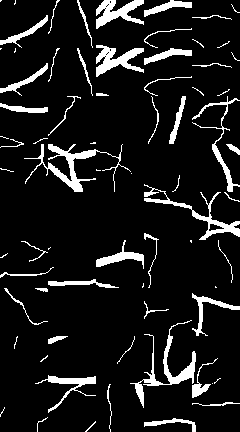

In [15]:
N_sample = min(patches_imgs_train.shape[0],40)
visualize(group_images(patches_imgs_train[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_imgs")#.show()
visualize(group_images(patches_masks_train[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks")#.show()

In [16]:
### data generator test


'./'+save_folder+'/'+name_experiment +name_experiment+ '_model.png'

'./Retina_Result/DRIVE_naive_attn_norm02_150000DRIVE_naive_attn_norm02_150000_model.png'

In [17]:
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]

model = naive_attn_unet(n_ch, patch_height, patch_width)  #the U-net model
print ("Check: final output of the network:")
print (model.output_shape)

plot(model, to_file= './'+save_folder+'/'+name_experiment+'/' +name_experiment+ '_model.png')   #check how the model looks like
#plot(model, to_file= name_experiment+'/'+name_experiment + '_model.png')   #check how the model looks like

json_string = model.to_json()
open('./'+save_folder+'/'+name_experiment+'/' +name_experiment+'_architecture.json', 'w').write(json_string)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 48, 48)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 48, 48)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 48, 48)   192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 48, 48)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

28253

In [18]:
print(int(config.get('training settings', 'num_subimgs')))

150000


### Training Session

In [19]:
'''
Keras provides a set of functions called callbacks: 
you can think of callbacks as events that will be triggered at certain training states. 
The callback we need for checkpointing is the ModelCheckpoint 
which provides all the features we need according to the checkpointing strategy we adopted in our example
'''

checkpointer = ModelCheckpoint(filepath='./'+save_folder+'/'+name_experiment+'/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

print('[training session] before mask unet func patch mask shape : ',patches_masks_train.shape)
patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
print('[training session] after mask unet func patch mask shape : ',patches_masks_train.shape)


history = model.fit(patches_imgs_train, patches_masks_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.2, callbacks=[checkpointer])
model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=True)


[training session] before mask unet func patch mask shape :  (150000, 1, 48, 48)
[training session] after mask unet func patch mask shape :  (150000, 2304, 2)
Train on 120000 samples, validate on 30000 samples
Epoch 1/150
120000/120000 [==============================] - 209s 2ms/step - loss: 0.2821 - dice_coef: 0.8294 - val_loss: 0.1700 - val_dice_coef: 0.8996

Epoch 00001: val_loss improved from inf to 0.17003, saving model to ./Retina_Result/DRIVE_naive_attn_norm02_150000/best_weights.h5
Epoch 2/150
120000/120000 [==============================] - 213s 2ms/step - loss: 0.1807 - dice_coef: 0.8911 - val_loss: 0.1551 - val_dice_coef: 0.9050

Epoch 00002: val_loss improved from 0.17003 to 0.15508, saving model to ./Retina_Result/DRIVE_naive_attn_norm02_150000/best_weights.h5
Epoch 3/150
120000/120000 [==============================] - 214s 2ms/step - loss: 0.1717 - dice_coef: 0.8962 - val_loss: 0.1508 - val_dice_coef: 0.9043

Epoch 00003: val_loss improved from 0.15508 to 0.15078, saving

In [24]:
history.history

{'dice_coef': [0.8294014417807262,
  0.8910772324244182,
  0.8961704160531362,
  0.8981942489941915,
  0.8995450358390809,
  0.9005379984060923,
  0.9034108185609182,
  0.9230222499370575,
  0.9252825016498566,
  0.9265274269580841,
  0.9275875656763712,
  0.9283609973112742,
  0.92914604900678,
  0.9298571897506713,
  0.9304580447832743,
  0.9310520376841227,
  0.9315481357574463,
  0.9320531469027201,
  0.9325222393671672,
  0.9329711858908335,
  0.9333588450431823,
  0.9337331047375997,
  0.9341445658683777,
  0.9344699871857961,
  0.9348386617342631,
  0.9350905140399933,
  0.9354266937732697,
  0.9357040080388387,
  0.9359615662733713,
  0.9361703077952067,
  0.9364026538530985,
  0.9365766592979431,
  0.9368104603449504,
  0.9369904455343883,
  0.9371859930038452,
  0.9373533996105194,
  0.9374979905605316,
  0.9376695650259653,
  0.9378441752433777,
  0.9379799851576487,
  0.9381076395670573,
  0.9382359672864278,
  0.938350866762797,
  0.9384858837286632,
  0.9385827768643697,


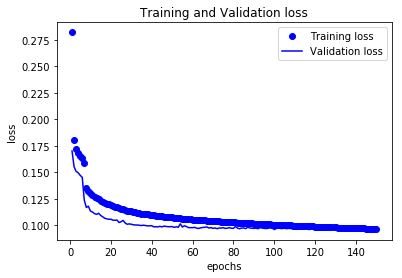

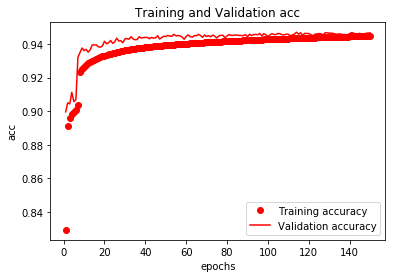

In [25]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss= history.history['val_loss']
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

epochs = range(1,len(acc) +1)

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.savefig('./'+save_folder+'/'+name_experiment+"/training_loss_result.png")
plt.figure()

plt.plot(epochs, acc, 'ro', label = "Training accuracy")
plt.plot(epochs, val_acc, 'r', label = "Validation accuracy")
plt.title("Training and Validation acc")
plt.xlabel("epochs")
plt.ylabel('acc')
plt.legend()


plt.savefig('./'+save_folder+'/'+name_experiment+"/training_acc_result.png")
plt.show()